# Introduction


In this project we aim to model a primary tumor classifier in order to apply what we have learnt at Artificial Intelligence and Learning, a subject that is taught at the Biomedical Engineering degree (Rey Juan Carlos University). 

We proceed to analyze the dataset we are going to work with hereunder.

The dataset we have chosen is a very known one about **primary tumors**. This database is mainly composed of **categorical multivariable features**. As a result, this is a **classification** problem. 

The **total number of patients** we have is **339** where as the **number of features** is **18**. We will have to deal with a total of 225 missing values.

This dataset was created at November 1st 1988 by the **Oncology institut** of the universitary medical center of **Ljubljana, Slovenia**.

The **features** we are going to work with are:   
    -Tumor's class   
    -Patient's age    
    -Patient's gender    
    -Histological type of the tumor    
    -Degree of diferentiation (simmilarity with respect to the neighbouring cells)   
    -Starting place (bone, pleura, bone marrow, lung, lung pleura, peritoneum, liver, brain, skin, supraclavicular region, axilar region, mediastinum or abdominal region).   

A **primary tumor** is a tumor that grows on the anatomical place where the progression started; this tumor creates a cancerous mass (no methastasis). *This is the main difference when compared with secondary tumors*, which are the ones that get distributed throughout the rest of the body.


The distribution on our 22 classes is not uniform; we have an imbalanced dataset.

# Analysis code: Data visualization.
---



We proceed to read the dataset in order to see its aspect.

In [1]:
import pandas as pd 
import statistics as stats
import sklearn.model_selection as skm
columnas = ['class', 'age', 'sex', 'histologic-type', 'degree-of-diffe', 'bone', 'bone-marrow', 'lung', 'pleura', 'peritoneum', 'liver', 'brain', 'skin', 'neck', 'supraclavicular', 'axillar', 'mediastinum', 'abdominal']
file = pd.read_csv('primary-tumor.data', sep=',', names = columnas) 
#We have to change the name of features as it was originally changed to numbers; the idea
#is to improve the interpretability of the data.

 # Preprocessing code: Integration, cleaning, transformation and data reduction. 
---


We proceed hereunder to process the data we have in order to work with the optimal features of our data and get the best results on classification. 

In [2]:
import sklearn as sk
import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import seaborn as sns
import scipy as sc
import random
!pip install miceforest 
import miceforest as mf

# Data cleaning

The first approximation we took was to try to impute the best value for each cancer [1],[2],[3],[4],[5]. 
Afterwards, several type of techniques were investigated to delete NaN values[6], [7].   

We decided finally to use **MICE (multiple imputation by chained equations)** algorithm to deal with missing values. 

For those features with a single NaN value, we will assume it was lost by random (*Missing Completely at Random*).   
Otherwise, as we see a relatively higher percentage of missing values on rather important features (according to the literature), we opt to impute them instead of deleting them. 

In [3]:
#We change the ? values for NaN.
file = file.replace('?', np.nan)

#MICE's kernel is created, using 4 datasets. 
#Firstly, we convert all the features into categorical [8]
for col in columnas:
    file[col] = file[col].astype('category',copy=False)
kernel = mf.ImputationKernel(
  file,
  save_all_iterations=True,
  random_state=1
)
kernel.mice(3)
completed_dataset = kernel.complete_data(dataset=0, inplace=False) #our new imputed dataset
print(completed_dataset.isnull().sum(0))

#kernel.plot_imputed_distributions(wspace=0.35,hspace=0.4)
completed_dataset.head(20)

class              0
age                0
sex                0
histologic-type    0
degree-of-diffe    0
bone               0
bone-marrow        0
lung               0
pleura             0
peritoneum         0
liver              0
brain              0
skin               0
neck               0
supraclavicular    0
axillar            0
mediastinum        0
abdominal          0
dtype: int64


,class,age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,peritoneum,liver,brain,skin,neck,supraclavicular,axillar,mediastinum,abdominal
0,1,1,1,2,3,2,2,1,2,2,2,2,2,2,2,2,2,2
1,1,1,1,2,3,2,2,2,2,2,1,2,2,2,1,2,1,2
2,1,1,2,2,3,1,2,2,2,2,2,2,2,2,2,2,1,2
3,1,1,2,2,3,1,2,1,1,2,2,2,2,2,2,2,1,2
4,1,1,2,2,3,1,2,1,1,2,2,2,2,2,2,2,1,2
5,1,1,2,2,3,1,2,2,2,2,2,1,2,2,1,1,1,2
6,1,2,1,1,1,1,2,2,2,2,2,2,1,1,1,2,2,2
7,1,2,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2
8,1,2,1,1,1,2,2,2,2,2,2,2,2,1,2,2,2,2
9,1,2,1,1,2,1,2,2,2,2,2,2,1,1,1,2,2,2


Transformación de datos.

In [4]:
#Dado que no tener los datos en una base 0/1/2... puede afectar a los valores de ciertas correlaciones, 
#(método de Kendall, que usaremos más adelante) pasamos a transformar los datos para obtener el resultado más preciso posible.

clase=completed_dataset["class"]
input = completed_dataset.drop(columns='class')
columna_sin_clase = ['age', 'sex', 'histologic-type', 'degree-of-diffe', 'bone', 'bone-marrow', 'lung', 'pleura', 'peritoneum', 'liver', 'brain', 'skin', 'neck', 'supraclavicular', 'axillar', 'mediastinum', 'abdominal']
for col in columna_sin_clase:
    input[col] = input[col].astype('int64',copy=False)
input = input.replace(to_replace = 1, value = 0, regex = True)
input = input.replace(to_replace = 2, value = 1, regex = True)
input = input.replace(to_replace = 3, value = 2, regex = True)

completed_dataset=input
completed_dataset["class"]=clase

input.head(20)




,age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,peritoneum,liver,brain,skin,neck,supraclavicular,axillar,mediastinum,abdominal,class
0,0,0,1,2,1,1,0,1,1,1,1,1,1,1,1,1,1,1
1,0,0,1,2,1,1,1,1,1,0,1,1,1,0,1,0,1,1
2,0,1,1,2,0,1,1,1,1,1,1,1,1,1,1,0,1,1
3,0,1,1,2,0,1,0,0,1,1,1,1,1,1,1,0,1,1
4,0,1,1,2,0,1,0,0,1,1,1,1,1,1,1,0,1,1
5,0,1,1,2,0,1,1,1,1,1,0,1,1,0,0,0,1,1
6,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,1
7,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1
9,1,0,0,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'histologic-type'}>,
        <Axes: title={'center': 'degree-of-diffe'}>],
       [<Axes: title={'center': 'bone'}>,
        <Axes: title={'center': 'bone-marrow'}>,
        <Axes: title={'center': 'lung'}>,
        <Axes: title={'center': 'pleura'}>],
       [<Axes: title={'center': 'peritoneum'}>,
        <Axes: title={'center': 'liver'}>,
        <Axes: title={'center': 'brain'}>,
        <Axes: title={'center': 'skin'}>],
       [<Axes: title={'center': 'neck'}>,
        <Axes: title={'center': 'supraclavicular'}>,
        <Axes: title={'center': 'axillar'}>,
        <Axes: title={'center': 'mediastinum'}>],
       [<Axes: title={'center': 'abdominal'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

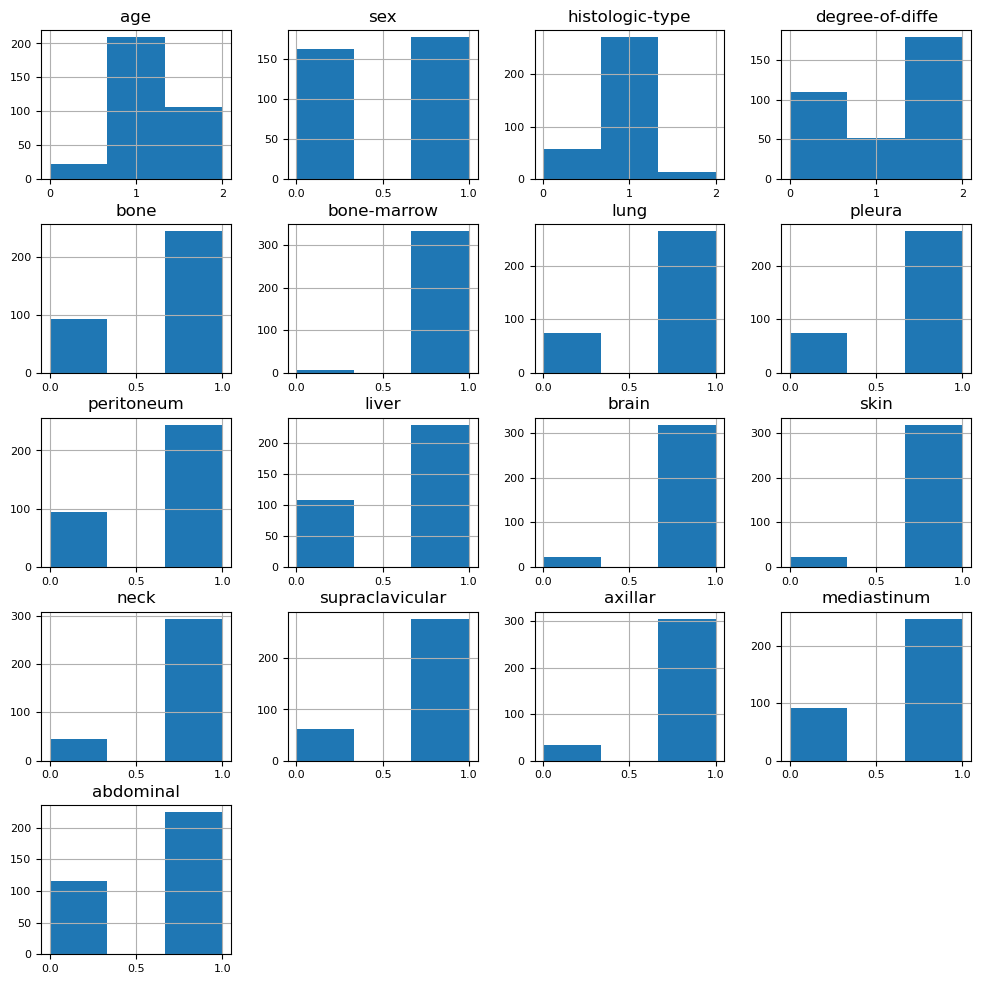

In [5]:
completed_dataset.hist(figsize=(12, 12), bins=3, xlabelsize=8, ylabelsize=8) 

As we can see, the features are imbalanced, that is, we have categories inside our feature that have much more values than the rest. When we study our classes, we will see the same. We will assume the cost of this imbalance on precission and r2_score; nevertheless, in future versions of this project, we aim to balance properly this dataset.

<Axes: >

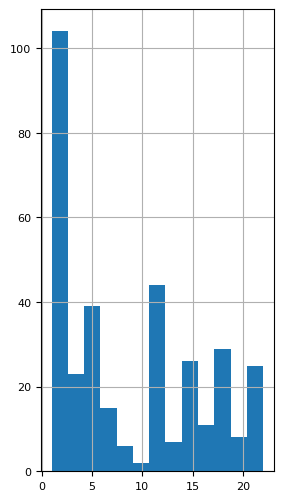

In [6]:
completed_dataset["class"].hist(figsize=(3, 6), bins=13, xlabelsize=8, ylabelsize=8)


# Data reduction Phase

In [7]:
import scipy.stats as stats
#We will calculate Cramer's Phi statistic, which is a variant of Student's T for ordinal discrete features.
X2 = stats.chi2_contingency(input, correction=False)[0]
n = np.sum(input)
minDim = min(input.shape)-1


V = np.sqrt((X2/n) / minDim)

print(V)

#The idea is to complement the Kendall data with Cramer data related to correlation. 


age                0.615711
sex                0.951833
histologic-type    0.737287
degree-of-diffe    0.626927
bone               0.809029
bone-marrow        0.694990
lung               0.779373
pleura             0.779373
peritoneum         0.810686
liver              0.834994
brain              0.710123
skin               0.710123
neck               0.737287
supraclavicular    0.759495
axillar            0.723913
mediastinum        0.805747
abdominal          0.846103
dtype: float64


/home/aitorchagon/anaconda3/envs/Proyectos/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return reduction(axis=axis, out=out, **passkwargs)


/tmp/ipykernel_16138/3300784912.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(input.corr(method = 'kendall'),linewidths=.1,cmap="YlGnBu", annot=True)


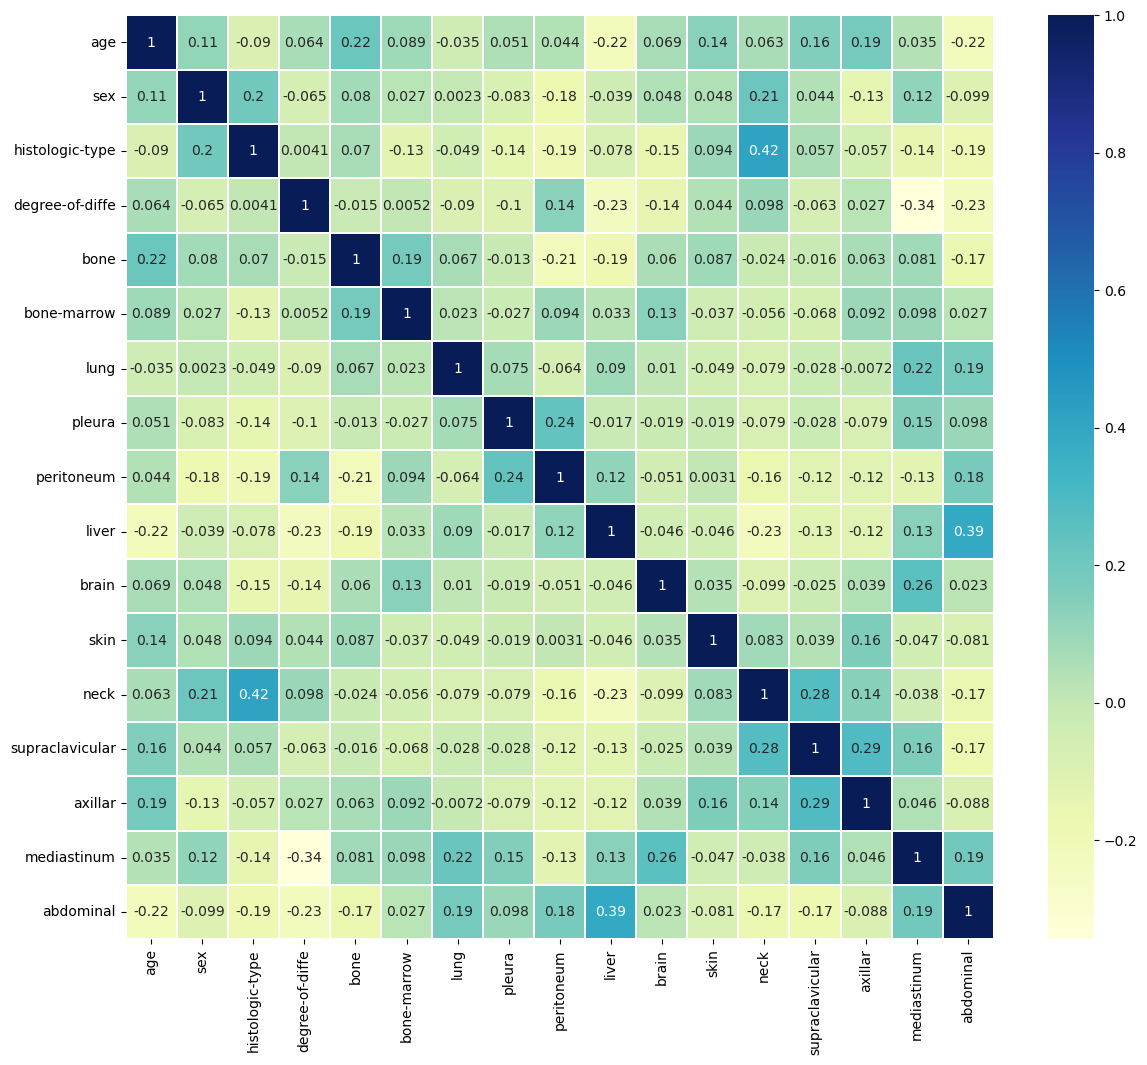

In [8]:
plt.figure(figsize=(14,12))
sns.heatmap(input.corr(method = 'kendall'),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

#As we can see hereunder, we do not have very correlated features. Kendall is more robust than Cramer's Phi
#because categorical features rarely follow a normal distribution (an assumption taken for Cramer's Phi)

To end this project, we see that, for several classes, the number of features is quite low. To solve this problem, we proceed to delete this "outliers" of the features and group those who are more similar (according to the state of the art on primary tumors). 

We proceed to delete feature number 9, merge features 19, 20, 18 on "utherus cancer" [11] .

We will delete vagina cancer and testicles cancer and merge colon cancer and rectus cancer on "colorrectal cancer"[12]. We will merge bladder cancer and prostatic cancer on bladder or prosthatic cancer [13]; we will, finally, delete duodenal cancer and salivary cancer as they are rarer in prevalence.

Our main idea is to avoid that logistic regression always chooses the most represented class (one of its best known biases) and delete those cancers that are never going to be chosen as a result of their lower probability.

Despite our database is going to be imbalanced, at this moment is going to be less imbalanced than before.

In [9]:
completed_dataset[completed_dataset["class"] == 9]

completed_dataset[completed_dataset['class'] == 20] 
completed_dataset.at[313, 'class'] = 18
completed_dataset.at[312, 'class'] = 18
completed_dataset[completed_dataset['class'] == 19]
lista = [306, 307, 308, 309, 310, 311]
for i in range(len(lista)):
  completed_dataset.at[lista[i], 'class'] = 18
completed_dataset[completed_dataset['class'] == 21] 

completed_dataset.drop(314,axis=0, inplace=True) 

completed_dataset[completed_dataset['class'] == 16] 

completed_dataset.drop(266, axis = 0, inplace=True)
completed_dataset[completed_dataset['class'] == 8] 

lista = [181, 182, 183, 184, 185, 186]
for i in range(len(lista)):
  completed_dataset.at[lista[i], 'class'] = 7
completed_dataset[completed_dataset['class'] == 15]  

lista = [264, 265]
for i in range(len(lista)):
  completed_dataset.at[lista[i], 'class'] = 17

completed_dataset.drop(166, axis = 0, inplace=True)



completed_dataset.drop(187, axis = 0, inplace=True)
completed_dataset.drop(188, axis = 0, inplace=True)

output = completed_dataset['class']
input = completed_dataset.drop(columns='class')
output.cat.remove_categories(removals = [6, 10, 20, 19, 21, 16, 8, 15], inplace = True)


/tmp/ipykernel_16138/2060962882.py:37: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  output.cat.remove_categories(removals = [6, 10, 20, 19, 21, 16, 8, 15], inplace = True)


Bibliografía:
1. Li, X., Xu, H., Yan, L., Gao, J., & Zhu, L. (2021). A Novel Clinical Nomogram for Predicting Cancer-Specific Survival in Adult Patients After Primary Surgery for Epithelial Ovarian Cancer: A Real-World Analysis Based on the Surveillance, Epidemiology, and End Results Database and External Validation in a Tertiary Center. Frontiers in oncology, 11, 670644. https://doi.org/10.3389/fonc.2021.670644
2. Lee, C. C., Ho, H. C., Su, Y. C., Yu, C. H., & Yang, C. C. (2015). Modified Tumor Classification With Inclusion of Tumor Characteristics Improves Discrimination and Prediction Accuracy in Oral and Hypopharyngeal Cancer Patients Who Underwent Surgery. Medicine, 94(27), e1114. https://doi.org/10.1097/MD.0000000000001114
3. Schlageter, M., Terracciano, L. M., D'Angelo, S., & Sorrentino, P. (2014). Histopathology of hepatocellular carcinoma. World journal of gastroenterology, 20(43), 15955–15964. https://doi.org/10.3748/wjg.v20.i43.15955
4. Caratozzolo E, Massani M, Recordare A, Ciardo L, Antoniutti M, Jelmoni A, Bassi N. Squamous cell liver cancer arising from an epidermoid cyst. J Hepatobiliary Pancreat Surg. 2001;8(5):490-3. doi: 10.1007/s005340100015. PMID: 11702262.
5. Dhasade, G. (2020, November 14). Ways To Handle Categorical Column Missing Data & Its Implementations. Medium. https://medium.com/analytics-vidhya/ways-to-handle-categorical-column-missing-data-its-implementations-15dc4a56893
6. Azur, M. J., Stuart, E. A., Frangakis, C., & Leaf, P. J. (2011). Multiple imputation by chained equations: what is it and how does it work?. International journal of methods in psychiatric research, 20(1), 40–49. https://doi.org/10.1002/mpr.329
7. Dolladille, C., Chrétien, B., Peyro-Saint-Paul, L. et al. Association Between Disease-Modifying Therapies Prescribed to Persons with Multiple Sclerosis and Cancer: a WHO Pharmacovigilance Database Analysis. Neurotherapeutics (2021). https://doi.org/10.1007/s13311-021-01073-y
8. miceforest. (2021, October 16). PyPI. https://pypi.org/project/miceforest/
9. Kinoshita Y, Singh A, Rovito PM Jr, Wang CY, Haas GP. Double primary cancers of the prostate and bladder: a literature review. Clin Prostate Cancer. 2004 Sep;3(2):83-6. doi: 10.3816/cgc.2004.n.016. PMID: 15479490.
10. Griffiths, C. D., McKechnie, T., Lee, Y., Springer, J. E., Doumouras, A. G., Hong, D., & Eskicioglu, C. (2021). Presentation and survival among patients with colorectal cancer before the age of screening: a systematic review and meta-analysis. Canadian journal of surgery. Journal canadien de chirurgie, 64(1), E91–E100. https://doi.org/10.1503/cjs.013019 
11. Wu, M., Gunning, W., & Ratnam, M. (1999, September). Expression of Folate Receptor Type α in Relation to Cell Type, Malignancy, and Differentiation in Ovary, Uterus, and Cervix. Cancer Epidemiology, Biomarkers and Prevention. Published. https://cebp.aacrjournals.org/content/8/9/775
12. Siegel, R.L., Miller, K.D., Goding Sauer, A., Fedewa, S.A., Butterly, L.F., Anderson, J.C., Cercek, A., Smith, R.A. and Jemal, A. (2020), Colorectal cancer statistics, 2020. CA A Cancer J Clin, 70: 145-164. https://doi.org/10.3322/caac.21601
13. Chun, T. Y. (1997). Coincidence of bladder and prostate cancer. Journal of Urology. Published. https://doi.org/10.1016/s0022-5347(01)65281-9

# Classification and regression using synthetic features: linear and non-linear 

To show our knowledge about continuous features and given that our entire dataset is categorical, we will add a synthetic random variable named Proba-of-rec that will use numerical data to show the "probability of recuperation from cancer". Given that is a synthetic variable, we do not recommend to obtain conclusions from these results in a clinical context. 


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

input_lr = input
columna_sin_clase = ['age', 'sex', 'histologic-type', 'degree-of-diffe', 'bone', 'bone-marrow', 'lung', 'pleura', 'peritoneum', 'liver', 'brain', 'skin', 'neck', 'supraclavicular', 'axillar', 'mediastinum', 'abdominal', 'proba-of-rec']
input_lr['proba-of-rec'] = np.random.randint(0,  100, size=len(input["age"]))

#Dividing our dataset in train and test.

X_train_lr, X_test_lr, Y_train_lr, Y_test_lr = train_test_split(input_lr, output, test_size = 0.3, random_state = 42)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train_lr, Y_train_lr)

train = []
validation = []
for train_index, validation_index in skf.split(X_train_lr, Y_train_lr):
  train_groups= []
  validation_groups= []
  train_groups.append(train_index)
  validation_groups.append(validation_index)
  train.append(train_groups)
  validation.append(validation_groups)


#We will assume that our data is a iid variable (identically distributed and independent); it is not a temporal series.
#This could be a limitation of our study that we are assuming for simplicity. [14]


regressor = LinearRegression()
scores_ecm = cross_val_score(regressor, X_train_lr, Y_train_lr, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(regressor, X_train_lr, Y_train_lr, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))


regressor = regressor.fit(X_train_lr,Y_train_lr) 
y_predt = regressor.predict(X_test_lr)

mse=mean_squared_error(Y_test_lr, y_predt)

print(mse)

r_squared=r2_score(Y_test_lr, y_predt)
print(r_squared)

#It is very probable that our bad results on r_squared are due to the synthetic variable and the use of linear regression
#on a mixed dataset; perhaps it would have been more useful to use decision trees or random forest, which 
#are rather more robust in this type of problems.

ECM Scores: [-36.60563161 -33.35500763 -31.76045693 -35.06455856 -38.12159738]
R2 Scores : [0.22448076 0.2991819  0.32982912 0.20557827 0.20601894]
34.98145042322706
0.2530177973683935
31.538367629216197
0.42323929620187073


14. (2021, May 1). Multiple Linear Regression using Python and Scikit Learn.  https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/
15. (2020, August 19). Why and how to Cross Validate a Model? - Towards Data Science. Medium. https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f?gi=c3c1a4538a47
16. (2020, March 13). The Importance Of Cross Validation In Machine Learning. Digital Vidya. https://www.digitalvidya.com/blog/cross-validation-in-machine-learning/

We are going to try to figure out in this cell to see which may be the best hyperparameter to see the relation
with the probability of recovering from cancer. 

| Feature         | MSE     | R2 |
|--------------|-----------|------------|
| Age | 58      |   -0.003     |
| Sex      | 50.52  |    0.125    |
| Histologic-type | 55 | 0.48 |
| Degree-of-diffe | 56.56 | 0.0213 |
| Bone | 57.47 | 0.005675 |
| Bone-marrow | 58.13 | -0.00577 |
|  Lung | 57.61 | 0.003 |
| Pleura | 57.85 | -0.0008 |
| Peritoneum | 55.59 | 0.038 |
| Liver | 58.97 | -0.02 |
| Brain | 54.395 | 0.05895 |
| Skin | 58.13 | -0.006 |
| Neck | 58.13 | -0.005 |
| Supraclavicular | 56.63 | 0.02 |
| Axillar | 50.91 | 0.119 |
| Mediastinum | 55.9 | 0.03 |
| Abdominal | 57.083 | 0.012 |

As it can be seen, the predictive performance of our algorithm taking into account the synthetical variable is worse given the randomness of the variable and its comparison with variables that are completely categorical. 

In [11]:
lista = [X_train_lr['proba-of-rec'], X_train_lr['sex']]
prueba = pd.concat(lista, axis=1)

lista1 = [X_test_lr['proba-of-rec'], X_test_lr['sex']]
prueba2 = pd.concat(lista1, axis = 1)

regressor = regressor.fit(prueba,Y_train_lr) 
y_pred = regressor.predict(prueba2)

# Calculamos el error cuadrático medio
mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

# Calculamos R^2
r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

47.108169217025285
0.13850516451323025


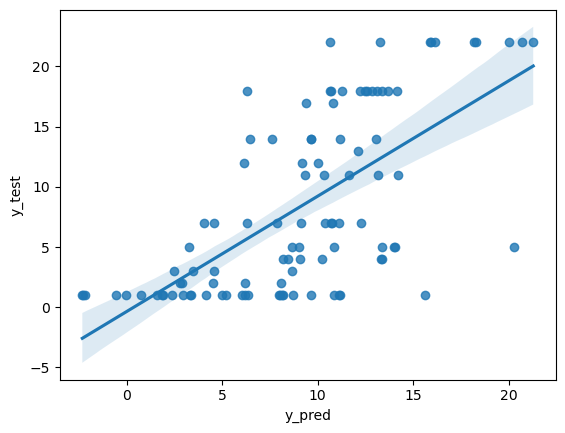

In [12]:
sns.regplot(x = y_predt, y = Y_test_lr)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()
#Como podemos ver, obedece mejor a una sigmoide que a una recta.

As it may be seen, given the sample distribution, the modelling of the decision frontier is much more efficient by using models such as Logistic Regression. 

Hereunder, we proceed to add another type of regressions based on Ridge, Lasso and Elastic Net to see how they may be better to improve the model.

In [13]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

regressor = Lasso()
scores_ecm = cross_val_score(regressor, X_train_lr, Y_train_lr, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(regressor, X_train_lr, Y_train_lr, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))



regressor = regressor.fit(X_train_lr,Y_train_lr) 
y_predt = regressor.predict(X_test_lr)


mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

# Calculamos R^2
r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

ECM Scores: [-45.50340356 -45.05905334 -44.49393223 -41.54373998 -45.549262  ]
R2 Scores : [0.03597443 0.05326959 0.06114267 0.05878611 0.05131857]
44.42987822182524
0.05209827236647555
47.108169217025285
0.13850516451323025


In [14]:
ridge = Ridge()
scores_ecm = cross_val_score(ridge, X_train_lr, Y_train_lr, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(ridge, X_train_lr, Y_train_lr, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))



regressor = ridge.fit(X_train_lr,Y_train_lr) 
y_predt = regressor.predict(X_test_lr)

mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

ECM Scores: [-37.19517444 -32.82550139 -31.00333483 -34.08922822 -38.12932905]
R2 Scores : [0.21199083 0.31030729 0.345805   0.22767533 0.20585791]
34.64851358715642
0.260327270680973
47.108169217025285
0.13850516451323025


In [15]:
lista = [X_train_lr['proba-of-rec'], X_train_lr['sex']]
prueba = pd.concat(lista, axis=1)

lista1 = [X_test_lr['proba-of-rec'], X_test_lr['sex']]
prueba2 = pd.concat(lista1, axis = 1)

regressor = ridge.fit(prueba,Y_train_lr) 
y_pred = regressor.predict(prueba2)

mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

47.13311129264764
0.13804903408633995


In [16]:
elasticnet = ElasticNet()
scores_ecm = cross_val_score(elasticnet, X_train_lr, Y_train_lr, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(elasticnet, X_train_lr, Y_train_lr, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))



regressor = elasticnet.fit(X_train_lr,Y_train_lr) 
y_predt = regressor.predict(X_test_lr)


mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)


r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)


ECM Scores: [-44.131289   -42.76825178 -41.97710513 -39.33843124 -44.46322466]
R2 Scores : [0.06504376 0.10140135 0.11424972 0.10874953 0.07393811]
42.53566036267178
0.09267649284943044
47.13311129264764
0.13804903408633995


In [17]:
lista = [X_train_lr['proba-of-rec'], X_train_lr['sex']]
prueba = pd.concat(lista, axis=1)

lista1 = [X_test_lr['proba-of-rec'], X_test_lr['sex']]
prueba2 = pd.concat(lista1, axis = 1)

regressor = elasticnet.fit(prueba,Y_train_lr) 
y_pred = regressor.predict(prueba2)


mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)


r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

52.536459245526984
0.03923482769469733


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

output = completed_dataset['class']
input = completed_dataset.drop(columns='class')

X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size = 0.2, random_state = 42)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train_lr, Y_train_lr)
train = []
validation = []

for train_index, validation_index in skf.split(X_train, Y_train):
    train_groups= []
    validation_groups= []
    train_groups.append(train_index)
    validation_groups.append(validation_index)
    train.append(train_groups)
    validation.append(validation_groups)


regressor = LogisticRegression(multi_class = 'multinomial', max_iter=1000, solver = 'saga' , penalty = 'none', n_jobs = -1)
scores_ecm = cross_val_score(regressor, X_train, Y_train, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(regressor, X_train, Y_train, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))

mse_results = []
r2_results = []

regressor = regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)


precision=accuracy_score(Y_test, y_pred)
print('Accuracy: {}'. format(precision))          

sensibilidad=recall_score(Y_test, y_pred, average = 'weighted')
print('Recall: {}'.format(sensibilidad))

/home/aitorchagon/anaconda3/envs/Proyectos/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/aitorchagon/anaconda3/envs/Proyectos/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/aitorchagon/anaconda3/envs/Proyectos/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/aitorchagon/anaconda3/envs/Proyectos/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the p

ECM Scores: [-38.33333333 -50.09259259 -72.49056604 -68.56603774 -77.0754717 ]
R2 Scores : [ 0.17376264 -0.1162908  -0.58943737 -0.42276098 -0.51833177]
61.311600279524804
0.3641167116532883


/home/aitorchagon/anaconda3/envs/Proyectos/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [67, 101]

Given the high quantity of classes we have, the repressentation of the Multiple Logistic Regression model turns out to be unfeasible. This may be a limitation of our project. Besides, working on the balancing of our dataset, we may consider to diminish the amount of our classes to improve on this aspect.    

When dealing with high dimensionality, we may try to improve it using univariant logistic regressions among features. Nonetheless, given the low correlation they have and the fact that we actually do not have to face with curse of dimensionality (number of samples >> 10 times number of features) we do not see necessary to diminish it a priori.

Lastly, diminish the number of classes on this specific case may generate a higher uncertainty in relation to which type of cancer we are predicting. As a result, we may have to reach a trade-off between the number of classes and the generalization/uncertainty of type of cancer to predict.

In [ ]:
logreg = LogisticRegression(C = 20, solver='saga', penalty='l1', multi_class = 'multinomial', max_iter=2000, n_jobs = -1)

regressor=logreg.fit(X_train, Y_train)

y_pred_lasso = logreg.predict(X_test)
scores_ecm = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))

cm = confusion_matrix(Y_test, y_pred_lasso)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

precision=accuracy_score(Y_test, y_pred_lasso)
print('Accuracy: {}'.format(precision))
              
sensibilidad_lasso=recall_score(Y_test, y_pred_lasso, average = 'weighted')
print('Recall: {}'.format(sensibilidad_lasso))

In [ ]:
logreg = LogisticRegression(C = 10, solver='saga', penalty='l2', multi_class = 'multinomial', max_iter=2000, n_jobs = -1)

regressor=logreg.fit(X_train, Y_train)

y_pred_ridge = logreg.predict(X_test)
scores_ecm = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))

cm = confusion_matrix(Y_test, y_pred_ridge)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

precision=accuracy_score(Y_test, y_pred_ridge)
print('Accuracy: {}'.format(precision))

sensibilidad_ridge=recall_score(Y_test, y_pred_ridge, average = 'weighted')
print('Recall: {}'.format(sensibilidad_ridge))

In [ ]:
logreg = LogisticRegression(C = 10, solver='saga', penalty='elasticnet', multi_class = 'multinomial', max_iter=2000, n_jobs = -1, l1_ratio = 0.15)


regressor=logreg.fit(X_train, Y_train)


y_pred_en = logreg.predict(X_test)
scores_ecm = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'r2', n_jobs = -1)


print("MSE Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))


cm = confusion_matrix(Y_test, y_pred_en)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

precision=accuracy_score(Y_test, y_pred_en)
print('Accuracy: {}'.format(precision))
            
#Calculamos la sensibilidad
sensibilidad_en=recall_score(Y_test, y_pred_en, average = 'weighted')
print('Recall: {}'.format(sensibilidad_en))